# Variational Quantum Autoencoder (VQAE) Tutorial

In this notebook, we’ll walk through the implementation of a Quantum Autoencoder (QAE) using Qiskit.  
QAEs aim to compress quantum states by removing redundancy—preserving only essential quantum information.

We will:
- Define the variational ansatz
- Build encoder/decoder architecture
- Train to compress and decompress quantum states
- Use the SWAP test to evaluate fidelity


# Step 1: Import Libraries and Set Up Sampler

We use Qiskit’s Sampler primitive to run circuits and get expectation values.

In [13]:
! pip install --upgrade pip
! pip install matplotlib
! pip install jupyter
! pip install qiskit==1.4.3 
! pip install qiskit-machine-learning
! pip install pylatexenc
! pip show qiskit

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\ruhiy\miniconda3\envs\qiskit_env\python.exe -m pip install --upgrade pip


Name: qiskit
Version: 1.4.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: C:\Users\ruhiy\miniconda3\envs\qiskit_env\Lib\site-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-machine-learning


### Test for successful installation of Qiskit and Qiskit Machine Learning Library // Probably going to delete

In [14]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

import qiskit.primitives.backend_sampler_v2
seed = 1376
algorithm_globals.random_seed = seed

# Use ad hoc data set for training and test data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)
vqc.fit(training_features, training_labels)

score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.95


Import Quantum ML Libraries and initialize Sampler

In [15]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42
sampler = Sampler()

# Step 2: Define the Ansatz

We define a variational ansatz based on RealAmplitudes. This provides parameterized RY rotations followed by CNOT entanglement layers.
This circuit is used both for encoding and decoding, ensuring symmetry.


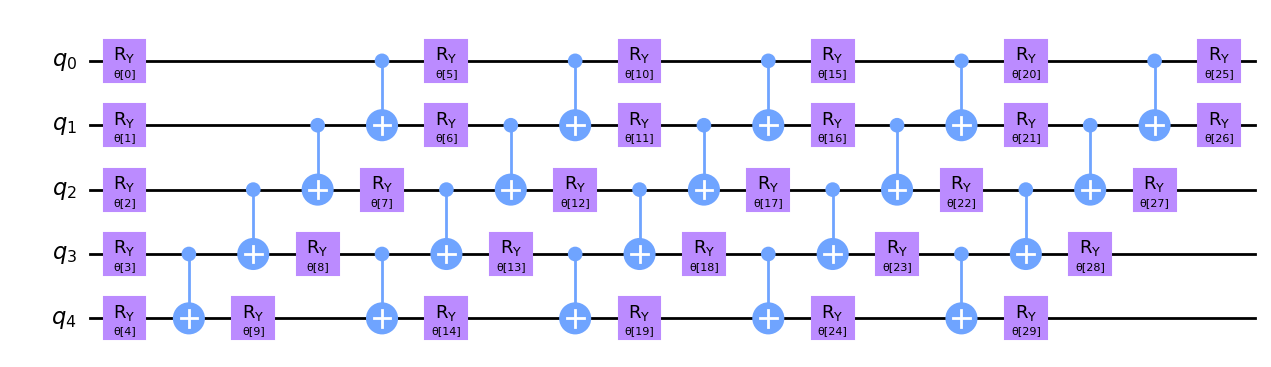

In [16]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)
    # return RealAmplitudes(num_qubits, reps=5, entanglement = "linear") # changes the measurement order

num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw(output="mpl", style="clifford")

# Step 3: Construct the Autoencoder Circuit

This function builds the complete autoencoder circuit:
- Applies the variational encoder
- Swaps the 'trash' qubits with a reference |0⟩ state using SWAP gates
- Includes an auxiliary qubit for the SWAP test


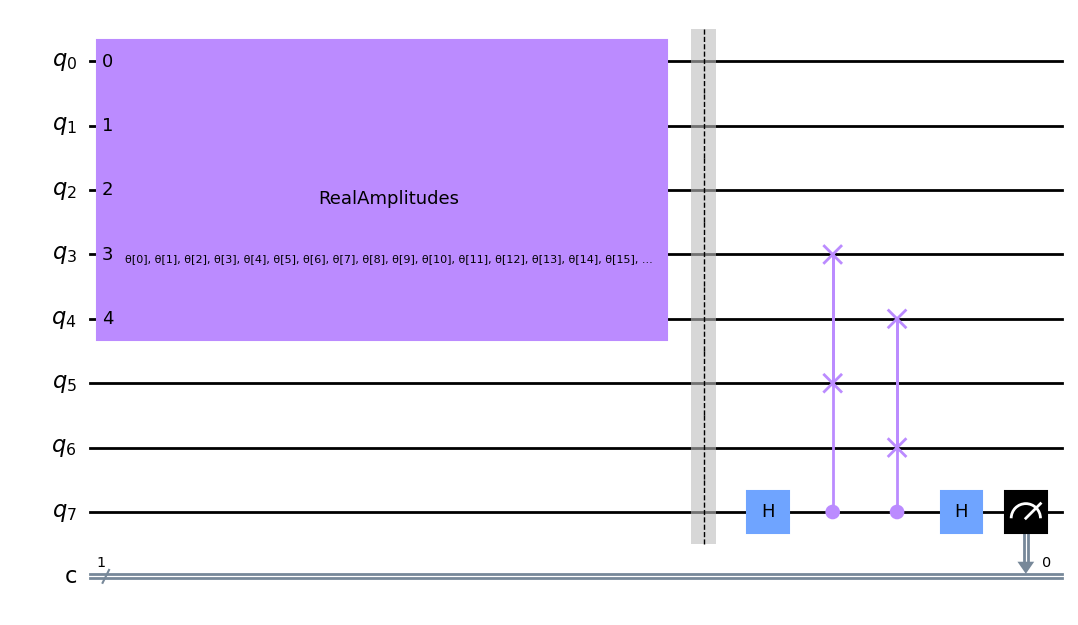

In [30]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw(output="mpl", style="clifford")

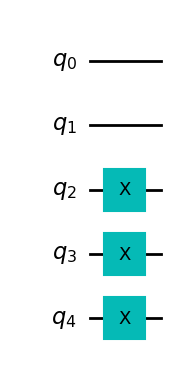

In [31]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl", style="clifford")

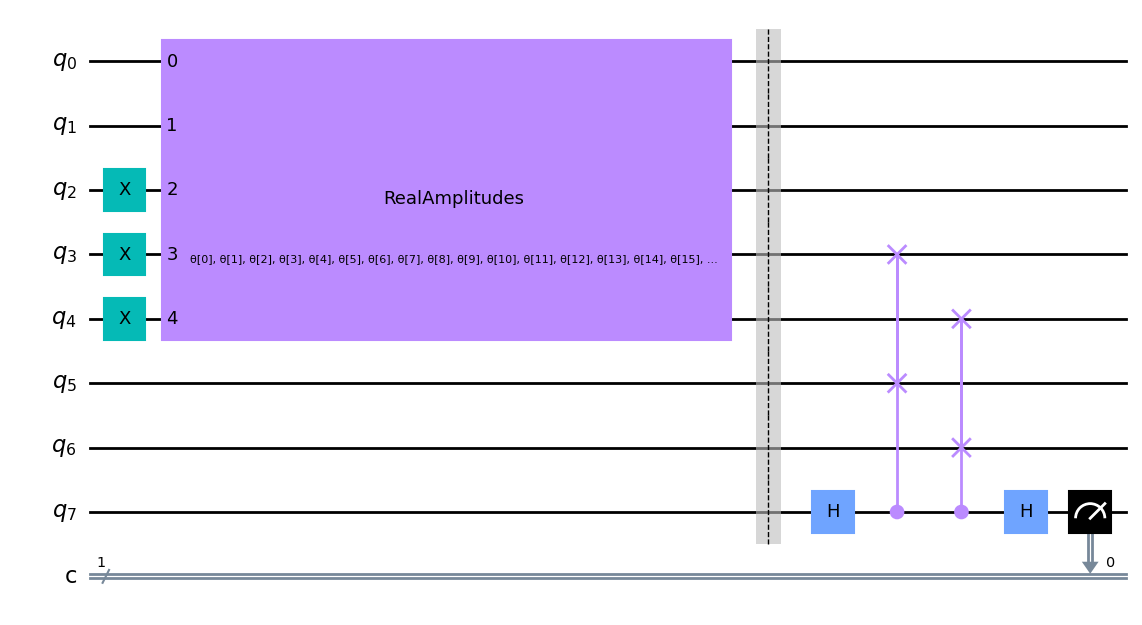

In [32]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw(output="mpl", style="clifford")

In [33]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


# Step 4: Define the Cost Function

We measure the auxiliary qubit.  
If the result is close to |0⟩, the two states are likely identical.  
Cost = 2 * L / M, where:
- L = number of 1s measured on the auxiliary qubit
- M = total number of measurements


In [34]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

# Step 5: Simulate and Evaluate

Here we run the circuit multiple times, collect the results from the sampler, and compute fidelity.  
This helps us quantify how well the QAE preserved the input.


## Choosing a Loss Function and Optimizer in Quantum Machine Learning

In variational quantum algorithms like the Quantum Autoencoder, training involves minimizing a loss function by adjusting gate parameters (the quantum equivalent of neural network weights). This is done using a classical optimizer.


### Loss Functions

| Loss Function          | Use Case                                                                 |
|------------------------|--------------------------------------------------------------------------|
| Fidelity Loss          | Measures similarity between output and target states: `1 - fidelity`     |
| Swap Test Loss         | Indirectly computes fidelity via interference using an ancilla qubit     |
| Expectation Value      | For energy minimization (e.g., VQE), minimize ⟨ψ(θ)|H|ψ(θ)⟩               |
| Cross-Entropy Loss     | Used in classification problems with QNN classifiers                     |

In this tutorial, we use Swap Test Fidelity Loss, which compares the reconstructed output with a reference using an ancilla qubit and controlled SWAP gates.


### Classical Optimizers

| Optimizer    | Type             | Requires Gradient | Best For                                            |
|--------------|------------------|--------------------|------------------------------------------------------|
| COBYLA       | Constrained       | No                 | Noisy or small-scale quantum circuits (good default) |
| SPSA         | Probabilistic     | No                 | Large parameter spaces, works well under noise       |
| L-BFGS-B     | Gradient-based    | Yes                | Smooth, differentiable loss (simulator only)         |
| ADAM         | Gradient-based    | Yes                | Hybrid QNNs using TorchConnector or PennyLane        |


### When to Use What

- COBYLA → Simple circuits, low noise, fast prototyping  
- SPSA → Noisy devices, many parameters, robust but slower  
- L-BFGS-B / ADAM → Simulated environments with access to gradients  
- Avoid gradient-based optimizers on real hardware without explicit support

Tip: Always plot the loss vs. iteration curve to check for convergence and optimizer stability.


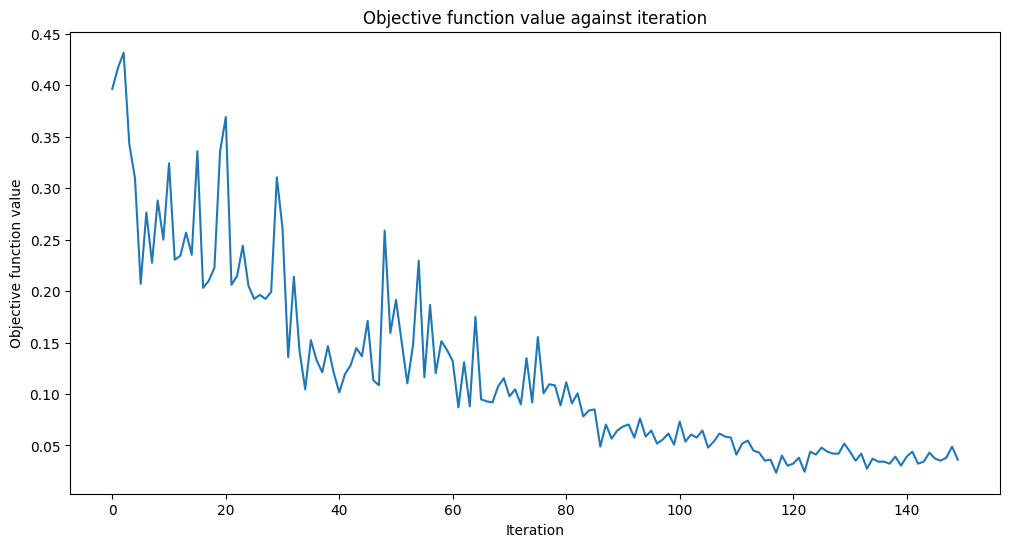

Fit in 16.20 seconds


In [35]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

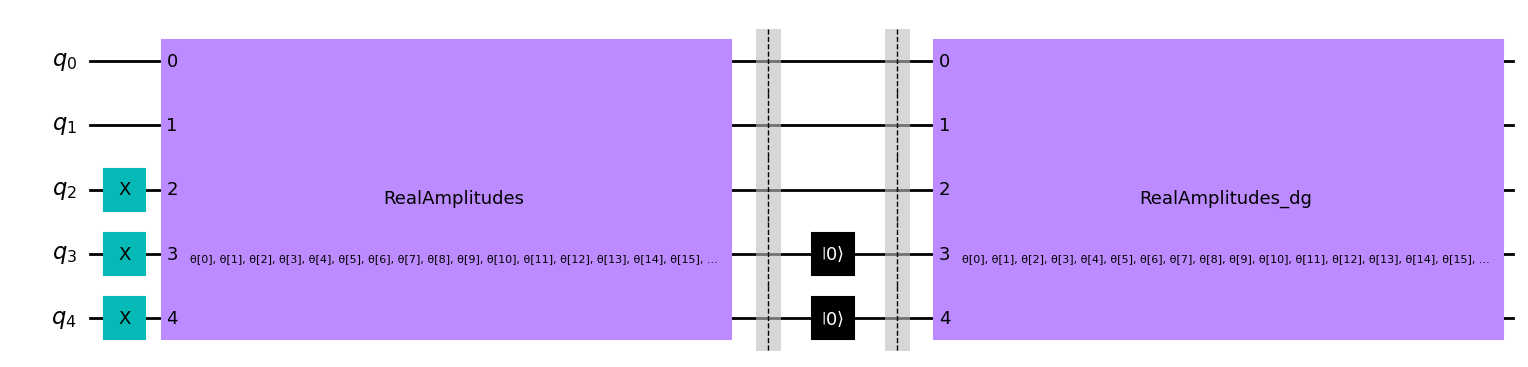

In [36]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw(output="mpl", style="clifford")

In [37]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [38]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9638308876689473


# Example of using Quantum Autoencoders for Image / Digital Compression

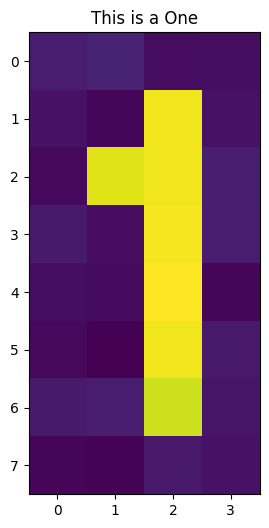

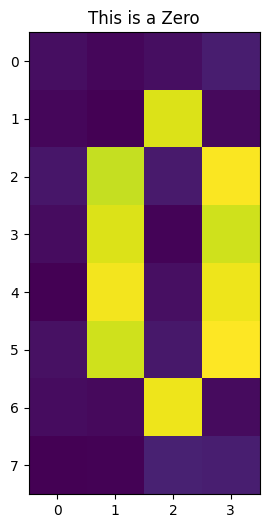

In [39]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

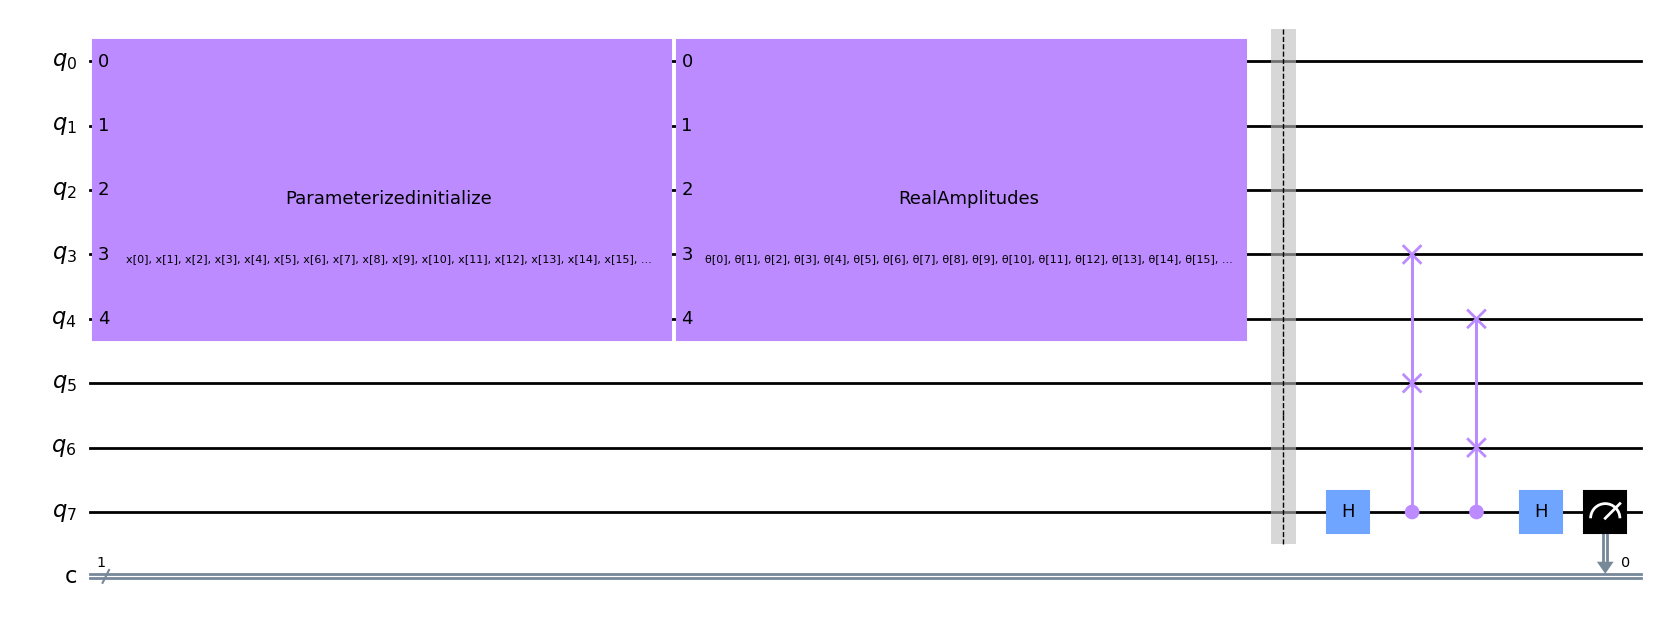

In [40]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="clifford")

In [41]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [42]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

In [43]:
# load pre-existing weights, only if you have access to them
with open("12_qae_initial_point.json", "r") as f:
    initial_point = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '12_qae_initial_point.json'

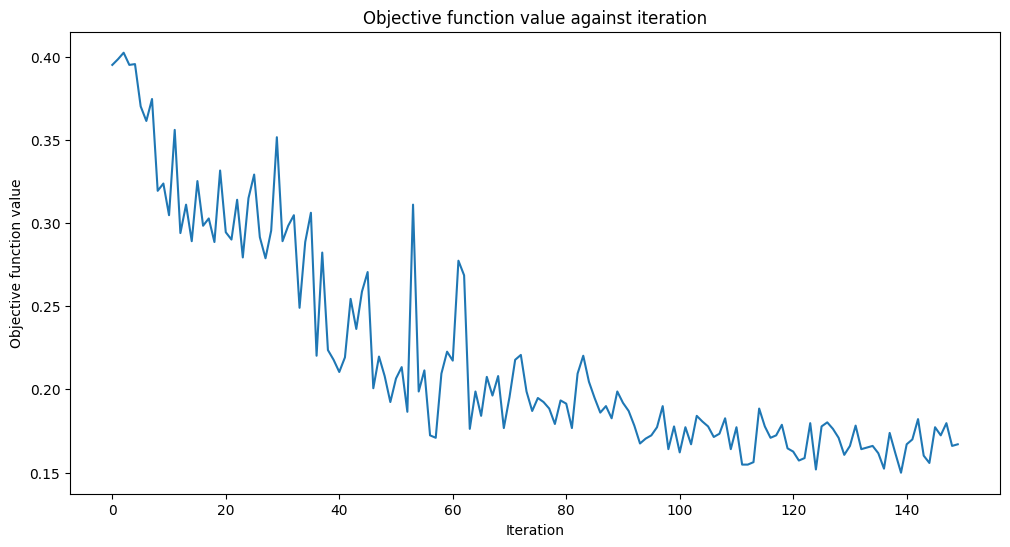

Fit in 17.93 seconds


In [44]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

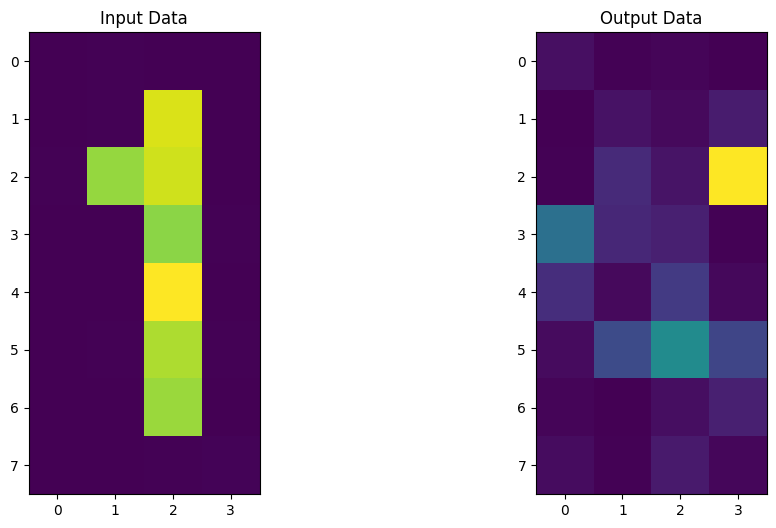

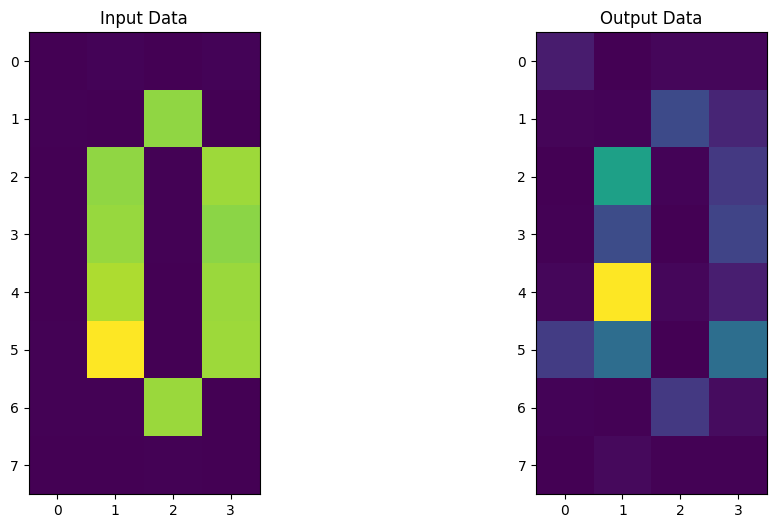

In [46]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

# Conclusion

- Quantum autoencoders compress quantum information efficiently.
- Using SWAP tests, we can quantify information loss.
- This QAE architecture is small, but the concept can scale to larger quantum systems for real-world tasks like quantum image compression or quantum chemistry.

You can try changing the ansatz depth or number of latent qubits to see how it affects compression quality!
